In [1]:
from utils import engine
import pandas as pd
from sqlalchemy.exc import ResourceClosedError

In [3]:
end_date = '20191231'
report_date = '20200710'


In [4]:
def execute(sql):
    try:
        df = pd.read_sql(sql, engine)
        return df
    except ResourceClosedError:
        print("No data return!")

In [12]:
## 行业PE
execute('''drop table if exists pe_industry''')
execute(f'''
create table pe_industry as
select trade_date,industry, round(avg(pe_ttm),2) pe_ttm_ind from stock_basic sb
join daily_basic d on sb.ts_code = d.ts_code
where d.trade_date='{report_date}'
group by industry
''')

No data return!
No data return!


In [13]:
## 个股PE
execute('''drop table if exists pe_history''')
execute(f'''
create table pe_history as
select '{report_date}' report_date, sb.ts_code, sb.name, round(avg(pe),2) pe_his, round(avg(pe_ttm),2) pe_ttm_his 
from stock_basic sb
join daily_basic db on sb.ts_code=db.ts_code
where trade_date < '{report_date}'
and trade_date > replace(date_sub('{report_date}' , INTERVAL 360 DAY),'-','')
and trade_date > replace(date_add(sb.list_date , INTERVAL 60 DAY),'-','')
group by sb.ts_code
''')

No data return!
No data return!


In [20]:
## 分析
execute('''drop table if exists tmp_results''')
execute(f'''
create table tmp_results as
SELECT A.ts_code, sb.industry, sb.name, 
	   dt_roe_ttm, 
       avg_roe, 
       pe, pe_ttm,
       pe_ttm_ind,
       pe_his,
       pe_ttm_his,
       netprofit_yoy_ttm,
       dt_netprofit_yoy_ttm,
       grossprofit_margin_ttm,
       netprofit_margin_ttm
FROM (
	SELECT *, 
        row_number() over (partition by ts_code order by end_date desc) rn
    FROM tmp_ttm
    where end_date < '{report_date}'
    ) A
JOIN (
		SELECT name, round(AVG(dt_roe_ttm),2) AS avg_roe
		FROM tmp_ttm
		where end_date > replace(date_sub('{report_date}' , INTERVAL 540 DAY),'-','')
        and end_date < '{report_date}'
		GROUP BY name
	) B ON A.name = B.name
JOIN daily_basic C ON A.ts_code = C.ts_code
join stock_basic sb on A.ts_code = sb.ts_code
join pe_industry pi on sb.industry = pi.industry
join pe_history ph on A.ts_code = ph.ts_code
WHERE rn = 1
    and C.trade_date = '{report_date}'
    and dt_roe_ttm > 15
	AND avg_roe > 15
	AND (pe < 28 or pe_ttm < 28)
    and netprofit_yoy_ttm > 10
ORDER BY dt_roe_ttm DESC
''')


No data return!
No data return!


C:\miniconda\lib\site-packages\pymysql\cursors.py:170: Warning: (1681, 'Specifying number of digits for floating point data types is deprecated and will be removed in a future release.')
  result = self._query(query)


In [17]:
df_label = execute(f'''
select tr.*, f_tm/total_mv y
from(
	select *
    from daily_basic
	where ts_code in (select distinct ts_code from tmp_results) 
		and trade_date='{report_date}' 
) base
join (
	select ts_code, max(total_mv) f_tm from daily_basic
    where ts_code in (select distinct ts_code from tmp_results) 
		and trade_date > '{report_date}' and trade_date < replace(date_add('{report_date}', interval 90 day),"-","")
	group by ts_code
) F on base.ts_code=F.ts_code
join stock_basic sb
on base.ts_code=sb.ts_code
join tmp_results tr on base.ts_code=tr.ts_code
''')

In [19]:
print(f'''
select tr.*, f_tm/total_mv y
from(
	select *
    from daily_basic
	where ts_code in (select distinct ts_code from tmp_results) 
		and trade_date='{report_date}' 
) base
join (
	select ts_code, max(total_mv) f_tm from daily_basic
    where ts_code in (select distinct ts_code from tmp_results) 
		and trade_date > '{report_date}' and trade_date < replace(date_add('{report_date}', interval 90 day),"-","")
	group by ts_code
) F on base.ts_code=F.ts_code
join stock_basic sb
on base.ts_code=sb.ts_code
join tmp_results tr on base.ts_code=tr.ts_code
''')


select tr.*, f_tm/total_mv y
from(
	select *
    from daily_basic
	where ts_code in (select distinct ts_code from tmp_results) 
		and trade_date='20200710' 
) base
join (
	select ts_code, max(total_mv) f_tm from daily_basic
    where ts_code in (select distinct ts_code from tmp_results) 
		and trade_date > '20200710' and trade_date < replace(date_add('20200710', interval 90 day),"-","")
	group by ts_code
) F on base.ts_code=F.ts_code
join stock_basic sb
on base.ts_code=sb.ts_code
join tmp_results tr on base.ts_code=tr.ts_code



In [9]:
x = df_label.drop(['ts_code','industry','name', 'y'],axis=1)
y = df_label.loc[:,'y']

In [10]:
y = y>1.05

In [61]:
import lightgbm as lgb

In [62]:
lgr = lgb.LGBMClassifier()

In [63]:
lgr.fit(x,y,eval_set=(x,y))

[1]	training's binary_logloss: 0.591039
[2]	training's binary_logloss: 0.579846
[3]	training's binary_logloss: 0.569707
[4]	training's binary_logloss: 0.551139
[5]	training's binary_logloss: 0.541116
[6]	training's binary_logloss: 0.527099
[7]	training's binary_logloss: 0.519571
[8]	training's binary_logloss: 0.507838
[9]	training's binary_logloss: 0.500205
[10]	training's binary_logloss: 0.491352
[11]	training's binary_logloss: 0.485089
[12]	training's binary_logloss: 0.475252
[13]	training's binary_logloss: 0.469172
[14]	training's binary_logloss: 0.461613
[15]	training's binary_logloss: 0.456493
[16]	training's binary_logloss: 0.451752
[17]	training's binary_logloss: 0.446663
[18]	training's binary_logloss: 0.439612
[19]	training's binary_logloss: 0.432922
[20]	training's binary_logloss: 0.42956
[21]	training's binary_logloss: 0.425188
[22]	training's binary_logloss: 0.419044
[23]	training's binary_logloss: 0.413443
[24]	training's binary_logloss: 0.409956
[25]	training's binary_log

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
y_ = lgr.predict(x)

In [ ]:
sum(abs(y - y_)<0.01)/len(y_)

In [70]:
sum(y_ == y)/len(y)

0.9568965517241379

## PE 分布

In [7]:
from utils import engine
import pandas as pd
import numpy as np
import plotly.express as px

In [23]:
df.describe()

,pb
count,613.000000
mean,2.398600
std,0.293048
min,1.812900
25%,2.202200
50%,2.383100
75%,2.585700
max,3.211700


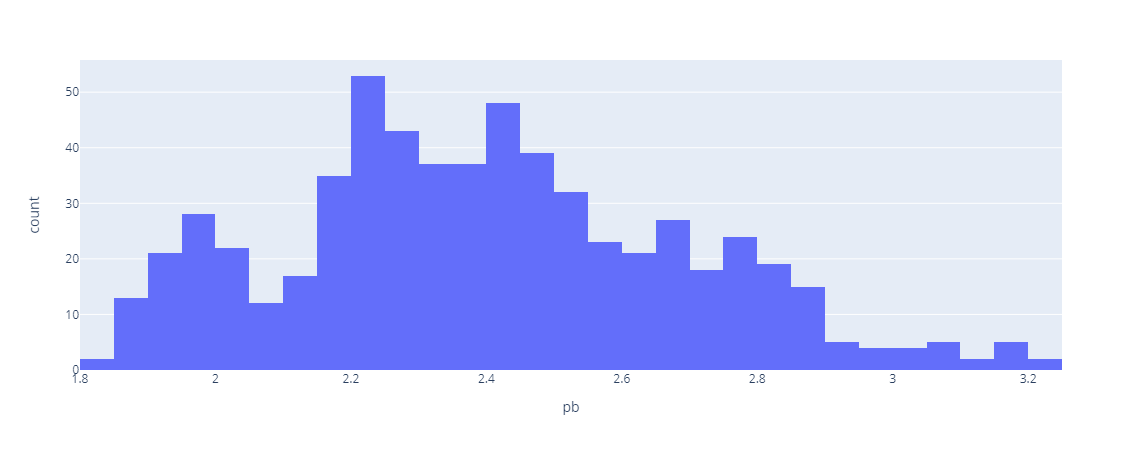

In [22]:
df = pd.read_sql('''
select pb from daily_basic
where ts_code='601318.SH' and trade_date>'20160101'
''', engine)
px.histogram(df,x='pb')

In [5]:
fig = go.Figure()

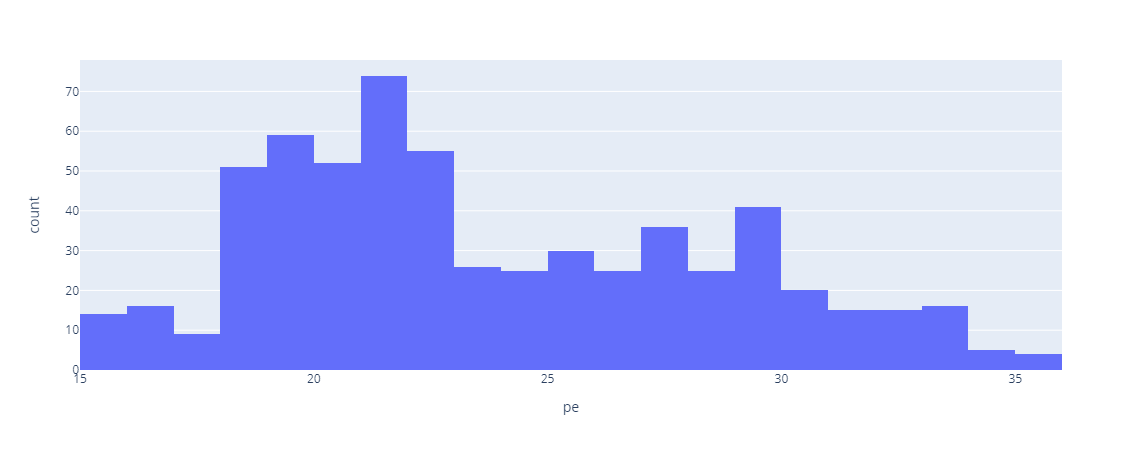

In [9]:
px.histogram(df,x='pe')

In [24]:
def N(x, mu, sigma):
    return 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-(x-mu)**2/2/sigma**2)

In [29]:
s = 0
for i in range(100):
    x = i*0.1 - 5
    s += N(x,0,1) * 0.1
    print(x,N(x,0,1),s)

-5.0 1.4867195147342977e-06 1.4867195147342977e-07
-4.9 2.438960745893352e-06 3.9256802606276505e-07
-4.8 3.961299091032075e-06 7.886979351659726e-07
-4.7 6.36982517886709e-06 1.4256804530526815e-06
-4.6 1.0140852065486758e-05 2.4397656596013574e-06
-4.5 1.5983741106905475e-05 4.038139770291905e-06
-4.4 2.4942471290053535e-05 6.532386899297259e-06
-4.3 3.853519674208713e-05 1.0385906573505973e-05
-4.2 5.8943067756539855e-05 1.628021334915996e-05
-4.1 8.926165717713293e-05 2.5206379066873254e-05
-4.0 0.00013383022576488537 3.858940164336179e-05
-3.9 0.00019865547139277272 5.845494878263906e-05
-3.8 0.00029194692579146027 8.764964136178509e-05
-3.7 0.00042478027055075143 0.00013012766841686023
-3.5999999999999996 0.000611901930113773 0.00019131786142823754
-3.5 0.0008726826950457602 0.0002785861309328136
-3.4 0.00123221916847302 0.0004018080477801156
-3.3 0.0017225689390536812 0.0005740649416854837
-3.2 0.0023840882014648404 0.0008124737618319677
-3.0999999999999996 0.0032668190561999247

In [31]:
np.sqrt(-0.8**2 / 2/np.log(0.1))

0.3727924814277249

In [33]:
x = np.arange(100)*0.1 - 5
y1 = N(x,0,1)
y2 = np.exp(-x**2/0.372**2)

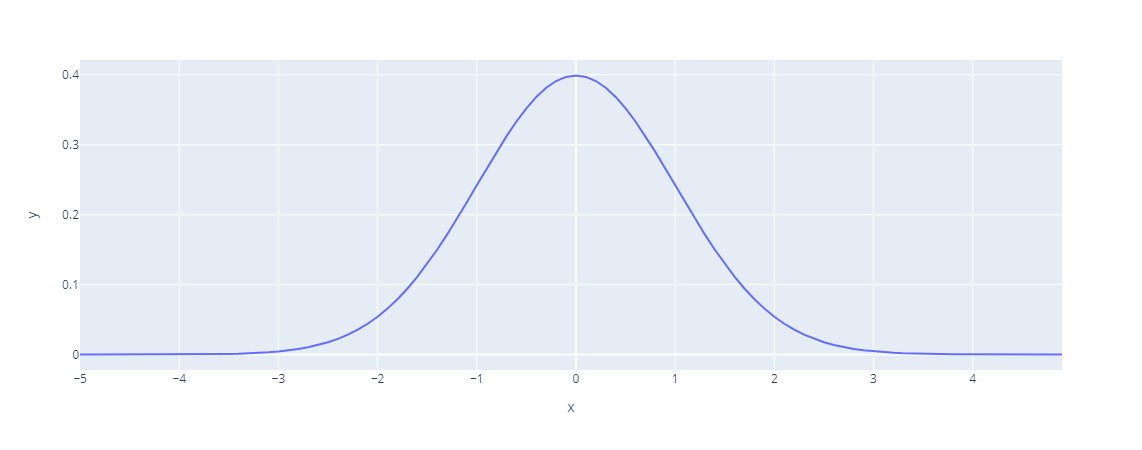

In [36]:
px.line(x=x,y=y1)

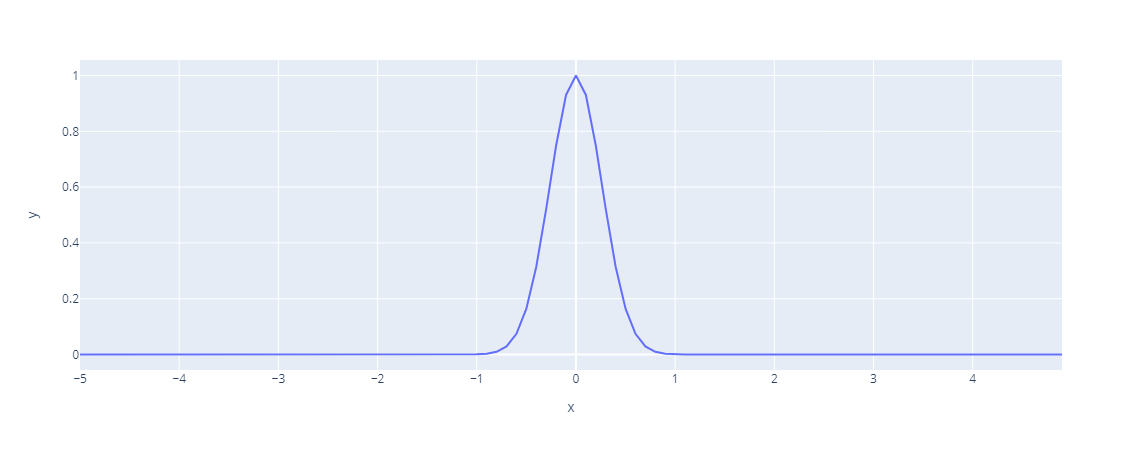

In [35]:

px.line(x=x,y=y2)

In [37]:
import tushare as ts

In [39]:
pro = ts.pro_api()

In [40]:
df = pro.index_classify(level='L2', src='SW')

Exception: 抱歉，您没有访问该接口的权限，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。